# Thevenin EC-Model
This model is build following the procedure presented by G. Plett in his course on Equivalent Circuit (EC) Models (http://mocha-java.uccs.edu/ECE5710/index.html)

### Imports

In [1]:
import context
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

import src.models.thevenin_model as thevenin

### Set hyperparameters

In [2]:
HYPER_PARAMETERS = {
    'gauss_sigma': 10,        # smoothing factor
    'd_sample': 3,            # subsampling ratio
    'stack': 0,               # battery stack used to extract the data from
    'cell': 4,                # specific battery cell to extract the data from          
    'convergence_steps': 50,  # time steps until the steady state is reached
}

TRAIN_PROFILE = 'Profile 10A'
t_0 = time.time()

### Load Profile

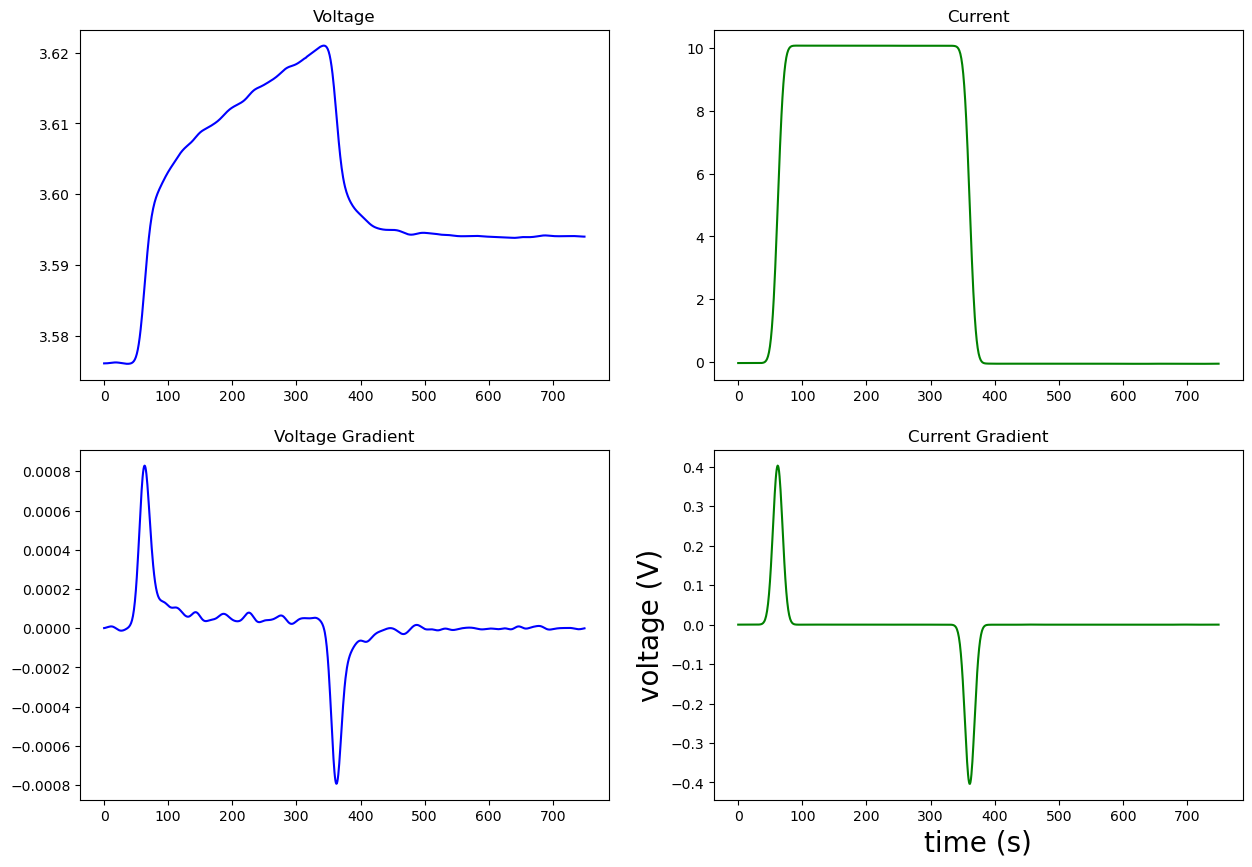

In [3]:
train_current, train_voltage = thevenin.load_profile(TRAIN_PROFILE, HYPER_PARAMETERS, visualize = True)

## Compute Model Parameters

### Step 1: Instantaneuos Voltage Change to deduce $R_0$
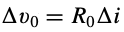

Time of Instantaneous Voltage Change (s): 362.25
delta_v_0 (V): 0.01862
---------------------------------------------------
Time of Instantaneous Current Change (s): 360.75
delta_i (A): 10.06724
---------------------------------------------------
R_0 (Ω): 0.00185
---------------------------------------------------
Test: delta_v = r_0 * delta_i = 0.01862


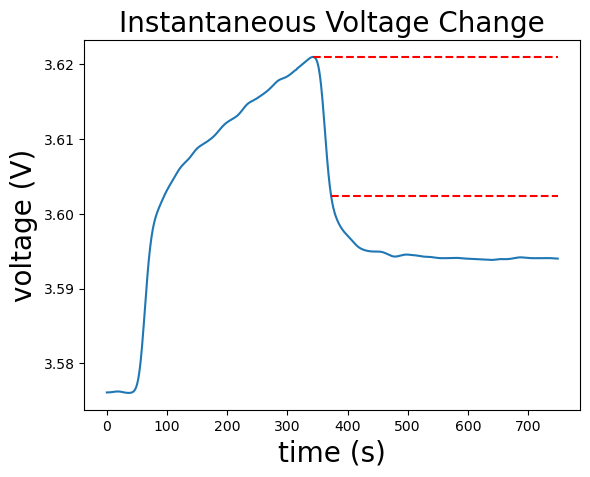

In [4]:
r_0, delta_i, max_volt_change_index = thevenin.identify_instant_volt_change(train_current, train_voltage)

### Step 2: Steady State Voltage Change to deduce $R_1$
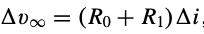

Steady State Time (s): 702.01
---------------------------------------------------
Steady State Voltage (V): 3.5941
---------------------------------------------------
delta_v_infty (V): 0.0269
---------------------------------------------------
R_1 (Ω): 0.000822
---------------------------------------------------
Test: delta_v_infty = (R_0 + R_1) * delta_i = 0.0269


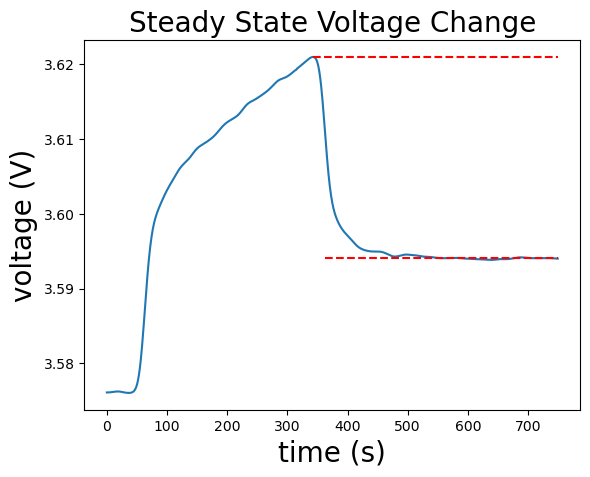

In [5]:
r_1, max_decrease_index, steady_state_time, max_voltage_index, steady_state_index = thevenin.identify_steady_state_voltage_change(train_current, train_voltage, r_0, delta_i, max_volt_change_index, HYPER_PARAMETERS)

### Step 3: Time to decay to Steady State to deduce $C_1$
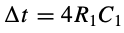

delta_t (s): 339.76
---------------------------------------------------
C_1 (F): 103279.98
---------------------------------------------------
Test: delta_t = 4 * R_1 * C_1 = 339.76
Test: R_1 * C_1 = 84.94


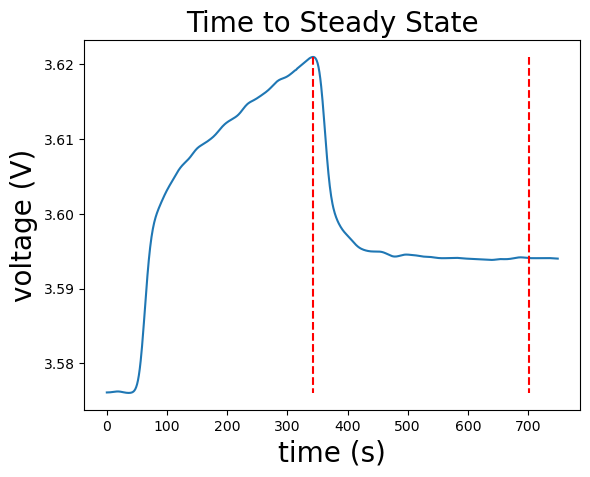

Training Time(s): 0.602


In [6]:
c_1 = thevenin.identify_steady_state_time(train_current, train_voltage, r_1, max_decrease_index, steady_state_time, max_voltage_index, steady_state_index)

t_delta = time.time() - t_0
print('Training Time(s):', round(t_delta, 3))

### Save Parameters

In [7]:
parameters = {
    'r_0': r_0,
    'r_1': r_1,
    'c_1': c_1,
}

MODEL_ID = str(np.random.randint(10000))
np.save('../../../models/T/theory_baseline-' + str(MODEL_ID) + '-parameters', parameters)
np.save('../../../models/T/theory_baseline-' + str(MODEL_ID) + '-hyperparameters', HYPER_PARAMETERS)
print('Model saved to /models/T/theory_baseline-' + str(MODEL_ID) +'...')

# add model id to hyper parameters
add_params = {
    'model_id': MODEL_ID,    # unique thevenin model id
}
HYPER_PARAMETERS.update(add_params)

Model saved to /models/T/theory_baseline-323...


## SOC OCV relationship

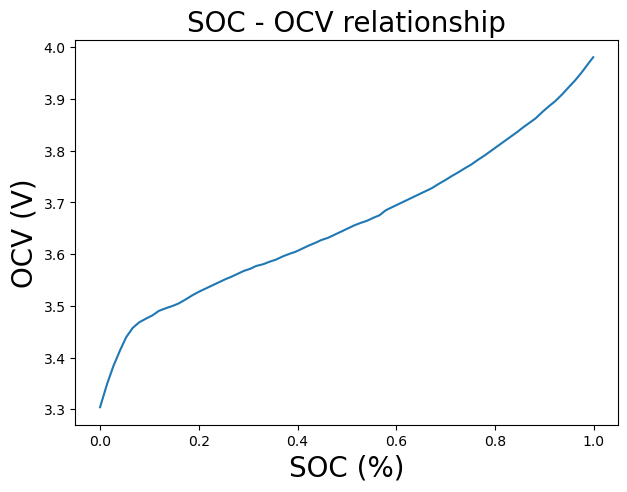

In [8]:
_ = thevenin.plot_OCV_curve()

## Voltage Prediction
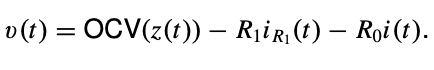

------------------- Params -------------------
v_0 (V): 3.57612
z_t0 (%): 31.4
Q (Ah): 33.2
------------------- Results -------------------


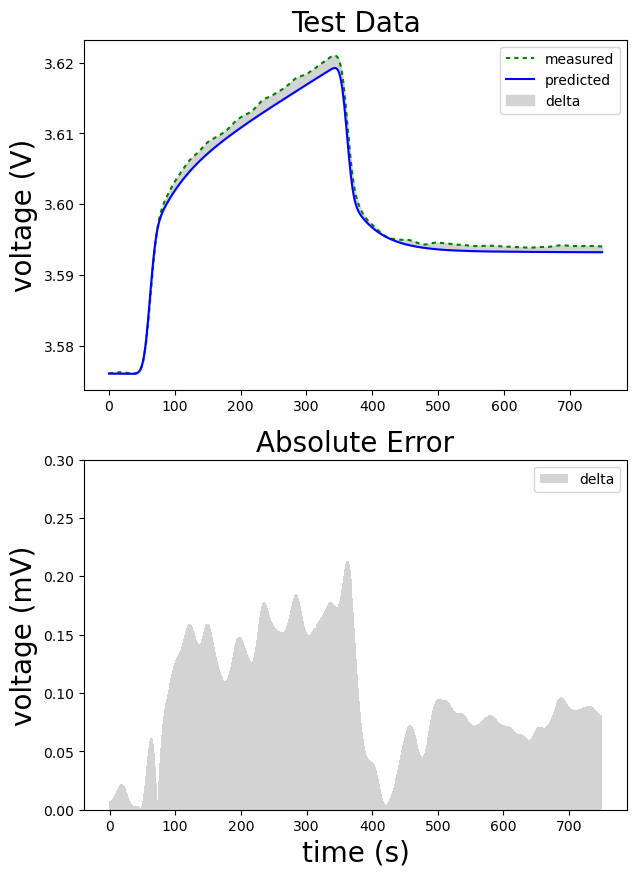

------------------- Evaluation -------------------
MSE(μV): 1.2
Saved plot to: ../../../reports/figures/theory_baseline-323-Profile 10A-test_profile.png


In [9]:
yhat = thevenin.vis_predict(TRAIN_PROFILE, r_0, r_1, c_1, HYPER_PARAMETERS)

## Test Profile

------------------- Params -------------------
v_0 (V): 3.56605
z_t0 (%): 28.7
Q (Ah): 33.2
------------------- Results -------------------


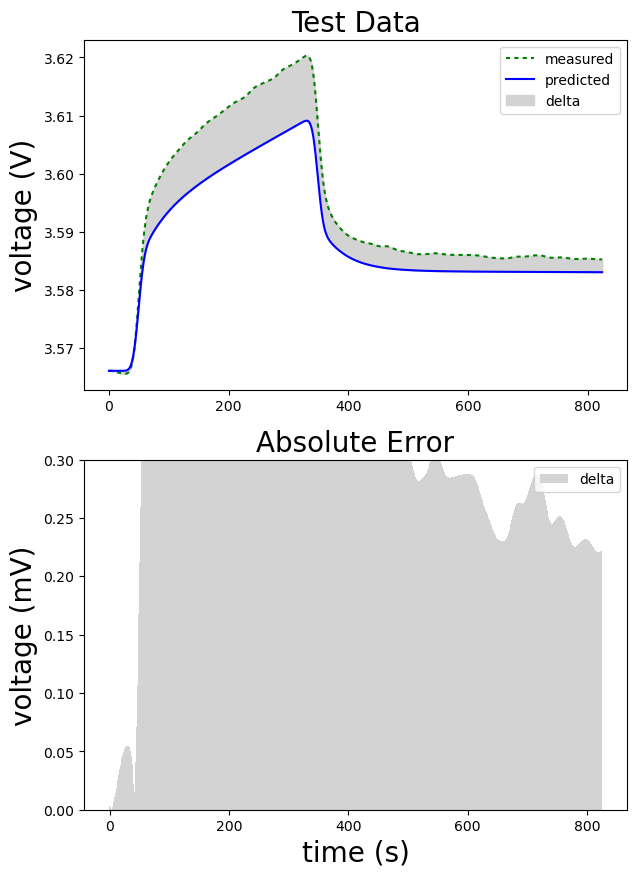

------------------- Evaluation -------------------
MSE(μV): 39.6
Saved plot to: ../../../reports/figures/theory_baseline-323-Profile 10A Run 040618-test_profile.png


In [10]:
TEST_PROFILE = 'Profile 10A Run 040618'
yhat = thevenin.vis_predict(TEST_PROFILE, r_0, r_1, c_1, HYPER_PARAMETERS)

## Test Use Cases

------------------- Params -------------------
v_0 (V): 3.57612
z_t0 (%): 31.4
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.55809
z_t0 (%): 27.0
Q (Ah): 33.2
------------------- Params -------------------
v_0 (V): 3.55286
z_t0 (%): 25.8
Q (Ah): 33.2
##############################################################
            Use Case 1    Use Case 2    Use Case 3
--------  ------------  ------------  ------------
MSE (μV)        1.2          18.5          26.8
MAE (V)         0.001         0.0036        0.0043
MaxE (V)        0.0021        0.0069        0.0076
##############################################################


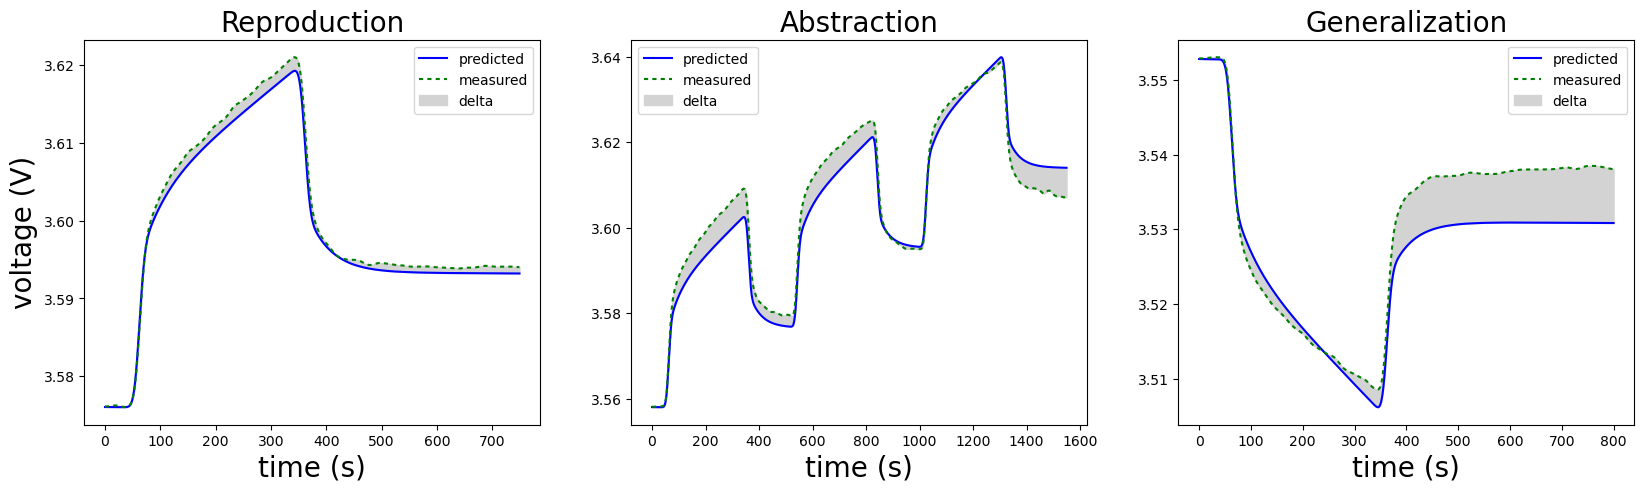

Saved plot to: ../../../reports/figures/theory_baseline-323-use_cases.png


In [11]:
profiles = ['Profile 10A', 'Profile 10A 3x', 'Profile -10A']
case_1_mse, case_2_mse, case_3_mse = thevenin.vis_predict_usecases(profiles, r_0, r_1, c_1, HYPER_PARAMETERS)

In [12]:
columns = ["Name", "Timestamp", "Model ID", "Train MSE", "Case 1 MSE", "Case 2 MSE", "Case 3 MSE"]
df = pd.DataFrame(columns=columns)

timestamp = datetime.datetime.now().isoformat(sep=" ", timespec="seconds")

new_df = pd.DataFrame([["Theory Baseline", timestamp, MODEL_ID, 0, case_1_mse, case_2_mse, case_3_mse]], columns=columns)

df = pd.concat(([df, new_df]))
df.to_csv('../../../reports/results/experiments.csv', mode='a', float_format='%.10f', index=False, header=False)